# Import Library & Load data

In [1]:
# Import Library
import cv2 as cv
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Opencv BGR channel format and plt reads images as RGB channel format
img = cv.imread("dataset\jerry_seinfeld\httpswwwticketscomuploadsartistsjerryseinfeldbilletsjpg.jpg")

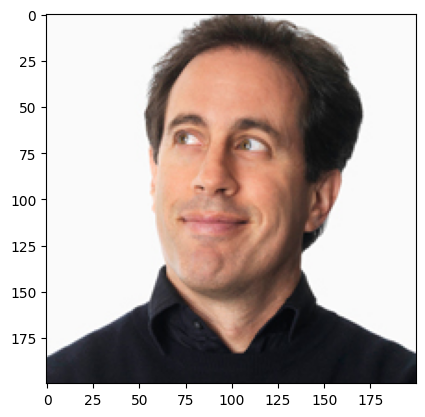

In [3]:
# Show image
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(img) # RGB 

In [4]:
# import MTCNN for image detection
from mtcnn.mtcnn import MTCNN

# Initiate MTCNN Model
img_detector = MTCNN()
results = img_detector.detect_faces(img)

1/1 [==============================] - 0s 107ms/step


In [5]:
# Show result
results

[{'box': [57, 22, 83, 118],
  'confidence': 0.9999992847442627,
  'keypoints': {'left_eye': (74, 66),
   'right_eye': (111, 71),
   'nose': (87, 91),
   'mouth_left': (72, 110),
   'mouth_right': (106, 113)}}]

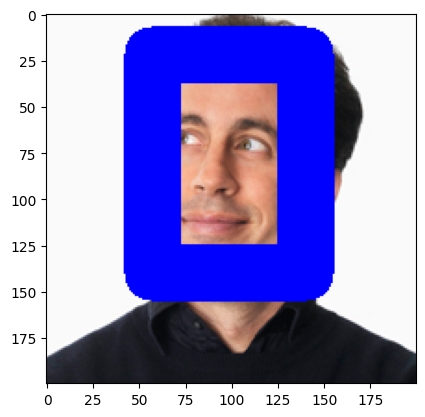

In [6]:
# Extract the coordinates and size of the bounding box from the first detection result
x, y, w, h = results[0]['box']

# Display the image with the drawn rectangle
img = cv.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 30)
plt.imshow(img)

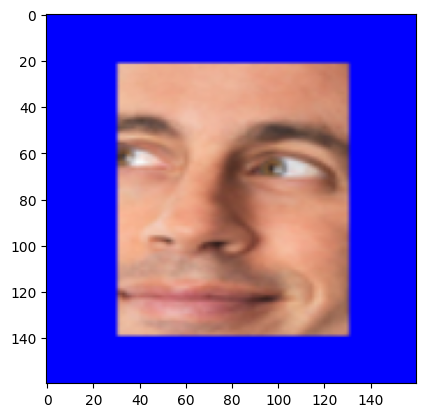

In [7]:
# resize image because Facenet takes as input 160x160
my_face = img[y:y+h, x:x+w]
my_face = cv.resize(my_face, (160,160))
plt.imshow(my_face)

# Automate the preprocessing 

In [8]:
# preprocessing
class FACELOADING:
    # initializes the FACELOADING class.
    def __init__(self, directory):
        self.directory = directory
        self.target_size = (160,160) # target size for face images
        self.X = [] # list to store face images
        self.Y = [] # list to store labels
        self.detector = MTCNN() # initialize the MTCNN face detector
    
    # function to extracts a face from a given image file.
    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        x,y,w,h = self.detector.detect_faces(img)[0]['box']
        x,y = abs(x), abs(y)
        face = img[y:y+h, x:x+w]
        face_arr = cv.resize(face, self.target_size)
        return face_arr
    
    # loads all faces from a given directory.
    def load_faces(self, dir):
        FACES = []
        for im_name in os.listdir(dir):
            try:
                path = dir + im_name
                single_face = self.extract_face(path)
                FACES.append(single_face)
            except Exception as e:
                pass
        return FACES
    
    # loads all faces and their corresponding labels from the root directory.
    def load_classes(self):
        for sub_dir in os.listdir(self.directory):
            path = self.directory +'/'+ sub_dir+'/'
            FACES = self.load_faces(path)
            labels = [sub_dir for _ in range(len(FACES))]
            print(f"Loaded successfully: {len(labels)}")
            self.X.extend(FACES)
            self.Y.extend(labels)
        
        return np.asarray(self.X), np.asarray(self.Y)

    # plots the loaded face images.
    def plot_images(self):
        plt.figure(figsize=(18,16))
        for num,image in enumerate(self.X):
            ncols = 3
            nrows = len(self.Y)//ncols + 1
            plt.subplot(nrows,ncols,num+1)
            plt.imshow(image)
            plt.axis('off')

In [10]:
# Initiate the FACELOADING class with the dataset directory path
faceloading = FACELOADING("dataset")

# Load the face images (X) and their corresponding labels (Y) from the dataset
X, Y = faceloading.load_classes()

1/1 [==============================] - 0s 25ms/step
Loaded successfully: 19
1/1 [==============================] - 0s 21ms/step
Loaded successfully: 22
1/1 [==============================] - 0s 24ms/step
Loaded successfully: 26
1/1 [==============================] - 0s 21ms/step
Loaded successfully: 24
1/1 [==============================] - 0s 25ms/step
Loaded successfully: 27


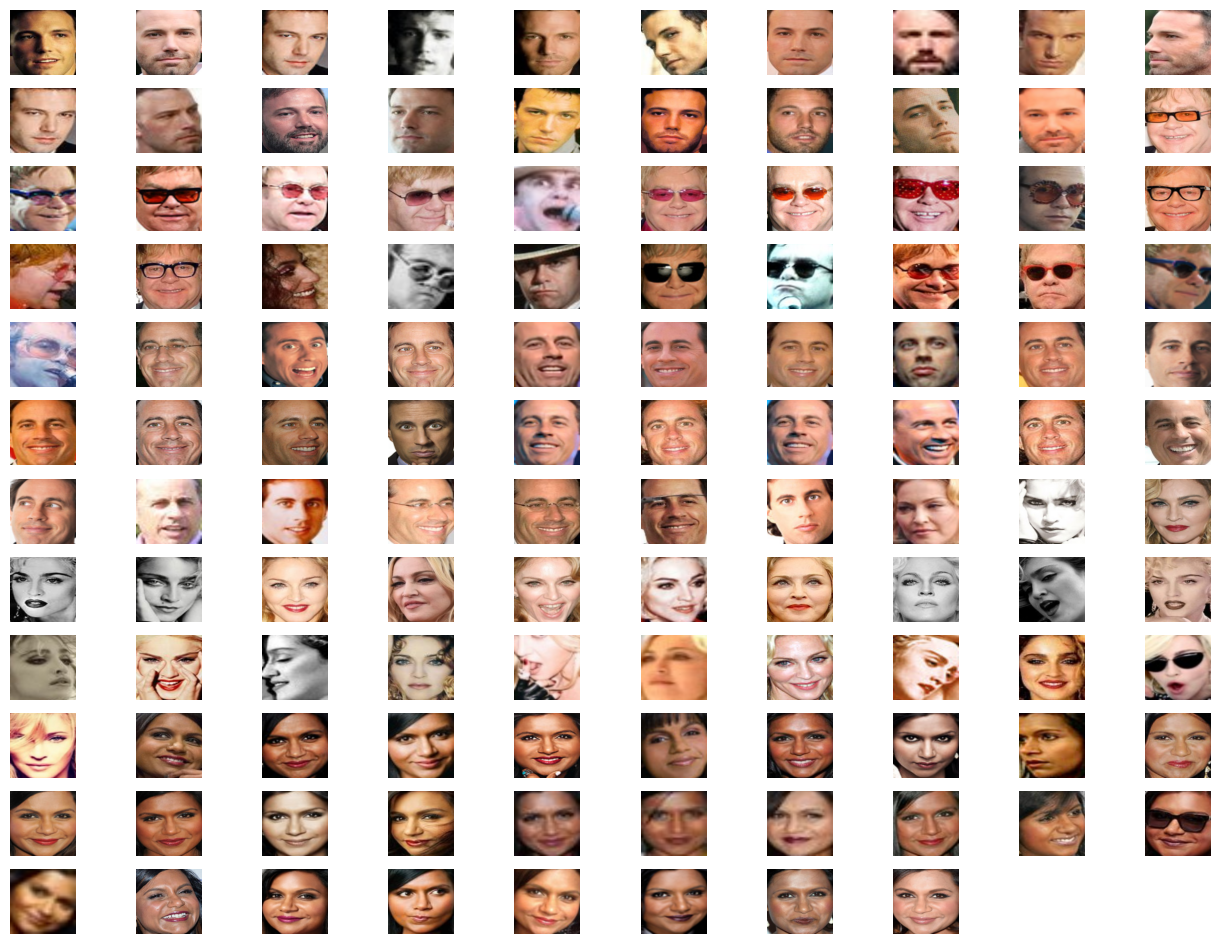

In [11]:
# display the loaded face images.
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 10
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

# FaceNet

In [12]:
# import library Facenet
from keras_facenet import FaceNet

# Instantiate the FaceNet model
embedder = FaceNet()

# Define a function to get the embedding of a face image
def get_embedding(face_img):
    face_img = face_img.astype('float32') # 3D(160x160x3)
    face_img = np.expand_dims(face_img, axis=0) 
    # 4D (Nonex160x160x3)
    yhat= embedder.embeddings(face_img)
    return yhat[0] # 512D image (1x1x512)

In [13]:
# Initialize an empty list to store embeddings
EMBEDDED_X = []

# Loop through each image in the dataset X to get the embedding for the current image and append it to the list
for img in X:
    EMBEDDED_X.append(get_embedding(img))

# Convert the list of embeddings to a NumPy array
EMBEDDED_X = np.asarray(EMBEDDED_X)

1/1 [==============================] - 0s 72ms/step


In [14]:
# Save the embeddings and labels into a compressed NumPy archive file (.npz)
np.savez_compressed('faces_embeddings_done_5classes.npz', EMBEDDED_X, Y)

# SVM Model

In [15]:
# import library label encoder
from sklearn.preprocessing import LabelEncoder

# Initiate a LabelEncoder object
encoder = LabelEncoder()

# Fit the LabelEncoder to the array Y to learn the classes
encoder.fit(Y)

# Transform the labels in Y to encoded labels
Y = encoder.transform(Y)

Text(0, 0.5, '0')

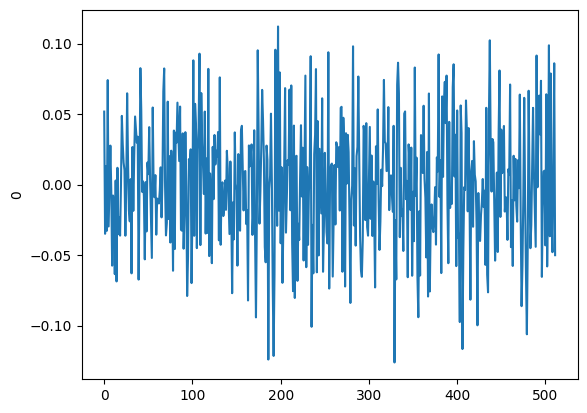

In [16]:
# Display plot values in EMBEDDED_X[0] and set the y-axis label to the value in Y[0]
plt.plot(EMBEDDED_X[0]) 
plt.ylabel(Y[0])

In [17]:
# Show labels
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4])

In [18]:
# Import train test split
from sklearn.model_selection import train_test_split

# Split the data into training (80%) and testing (20%)
X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, test_size=0.2, shuffle=True, random_state=17)

In [19]:
# Import model SVM
from sklearn.svm import SVC

# Initiate the SVM model with a linear kernel
model = SVC(kernel='linear', probability=True)

# Train the SVM model on the training data
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

## Evaluate Model

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix

# Predicting labels for the training and testing data using the trained model
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

# Calculating accuracy scores
train_accuracy = accuracy_score(Y_train, ypreds_train)
test_accuracy = accuracy_score(Y_test, ypreds_test)

# Print the accuracy scores
print(f'Training Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')

Training Accuracy: 1.0
Test Accuracy: 1.0


## Visualizing confusion matrix

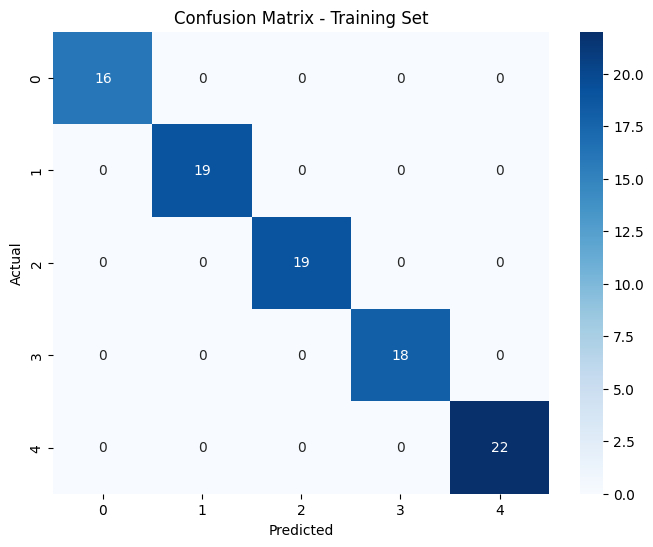

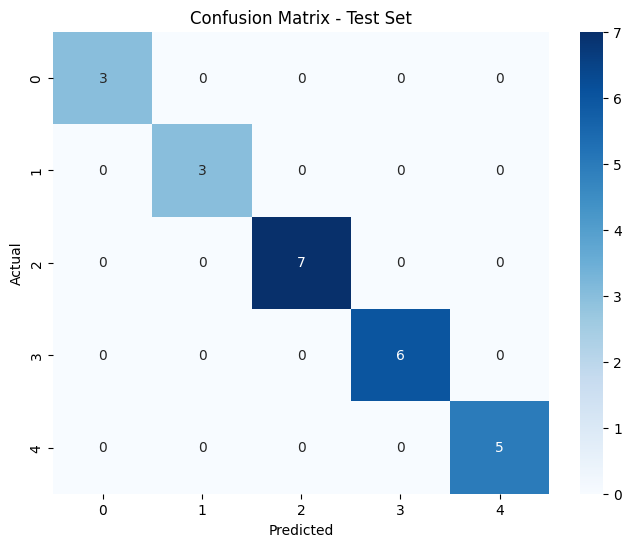

In [21]:
# Import seaborn for data visualization
import seaborn as sns

# Confusion matrix for training set
conf_matrix_train = confusion_matrix(Y_train, ypreds_train)

# Confusion matrix for test set
conf_matrix_test = confusion_matrix(Y_test, ypreds_test)

# Visualizing confusion matrix using seaborn heatmap
def plot_confusion_matrix(conf_matrix, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(conf_matrix_train, 'Confusion Matrix - Training Set')
plot_confusion_matrix(conf_matrix_test, 'Confusion Matrix - Test Set')

## Test predicting an image

1/1 [==============================] - 0s 24ms/step


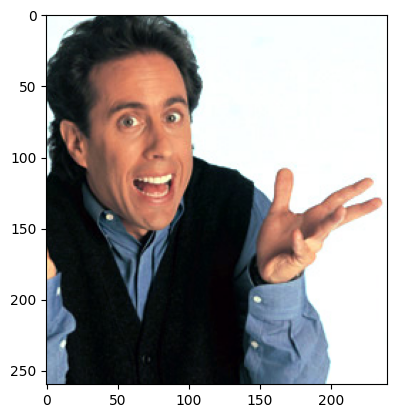

In [22]:
# Load the image
t_img = cv.imread("dataset\jerry_seinfeld\httpaurorasblogcomwpcontentuploadsjerryseinfeldpublicityshotjpg.jpg")

# Convert the image to RGB
t_img = cv.cvtColor(t_img, cv.COLOR_BGR2RGB)

# Show the image
plt.imshow(t_img) # RGB 

# Extract the coordinates and size of the bounding box from the first detection result
x,y,w,h = img_detector.detect_faces(t_img)[0]['box']

1/1 [==============================] - 0s 67ms/step


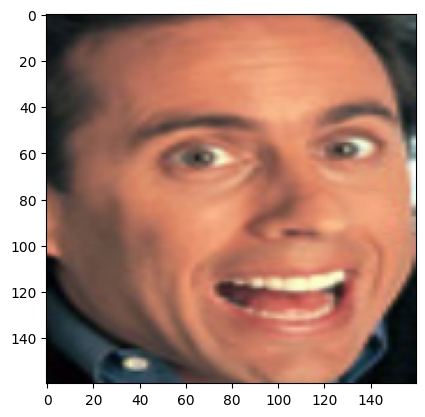

In [23]:
# Crop the detected face region from t_img using the bounding box coordinates
t_img = t_img[y:y+h, x:x+w]

# Resize the cropped face image to 160x160
t_img = cv.resize(t_img, (160,160))
plt.imshow(t_img)

# Get the embedding (feature vector) for the resized face image using the get_embedding function (Facenet)
test_img = get_embedding(t_img)

In [24]:
# Predict the label for the test image using the trained model
test_img = [test_img]
ypreds = model.predict(test_img)

In [25]:
# Show the result
ypreds

array([2])

In [26]:
# convert numeric to the corresponding class label
ypreds = encoder.inverse_transform(ypreds)

# print the result
print(f"Prediction result: {ypreds[0]}")

Prediction result: jerry_seinfeld


## Save Model

In [27]:
# Import library picke for saving model
import pickle

#save the model
with open('UD_facenet_svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)